In [2]:
"""
A simple example of the Stiefel landing algorithm on PCA problem
"""
from time import time

import matplotlib.pyplot as plt

import numpy as np

import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from models import VGG16, ResNet18

from solvers import GeneralizedLanding, LandingGeneralizedStiefel


import cupy as cp
from scipy.linalg import eigh

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [27]:
#model1 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
#model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained = True)

In [28]:
n_epochs = 15
device = 'cuda'

model1 = VGG16()
model1.to(device)

optimizer1 = optim.SGD(model1.parameters(), lr=1e-1, weight_decay=5e-4)

model2 = VGG16()
model2.to(device)

optimizer2 = optim.SGD(model2.parameters(), lr=1e-1, weight_decay=5e-4)


In [29]:
def train(model, optimizer, n_epochs):
    best_test_acc = 0.
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            logits = model(batch_x)
            loss = model.loss(logits, batch_y)
            train_loss =+ loss.item() * batch_x.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(train_loss)

        # Test
        model.eval()
        with torch.no_grad():
            test_loss = 0.
            correct = 0.
            for batch_x, batch_y in testloader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                logits = model(batch_x)
                loss = model.loss(logits, batch_y)
                test_loss += loss.item() * batch_x.size(0)
                correct += model.correct(logits, batch_y).item()
        print(100 * correct / len(testset))

In [5]:
train(model1, optimizer1, 8)
train(model2, optimizer2, 8)

89.8494815826416
47.2
61.94353103637695
64.77
38.10286045074463
73.63
34.310736656188965
73.28
21.460959911346436
72.27
38.13389539718628
74.99
13.128410577774048
80.65
14.188045263290405
81.41
110.63149452209473
44.48
104.88227844238281
54.63
65.80914497375488
67.96
56.83600902557373
66.43
48.522844314575195
73.84
28.74070405960083
79.23
22.080657482147217
75.08
16.238901615142822
76.77


In [30]:
model1 = torch.load('VGG16_1.pt')
model2 = torch.load('VGG16_2.pt')

In [31]:
torch.save(model1, 'VGG16_1.pt')
torch.save(model2, 'VGG16_2.pt')

In [32]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model1.fc2.register_forward_hook(get_activation('fc2'))

AttributeError: 'VGG16' object has no attribute 'fc2'

In [33]:
batch_idx, (batch_x, batch_y) = enumerate(trainloader).__next__()
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

In [34]:
with torch.no_grad():
    features1 = model1.features(batch_x).squeeze()
    features2 = model2.features(batch_x).squeeze()

p = 20
_, S1, Q1 = torch.linalg.svd(features1, full_matrices=False)
_, S2, Q2 = torch.linalg.svd(features2, full_matrices=False)
Q1 = Q1[:p,:].T / S1[:p]
Q2 = Q2[:p,:].T / S2[:p]

best_test_acc = 0.
p = 20
learning_rate = 0.00001
lambda_regul = 1
Q1 = torch.nn.Parameter(Q1)
Q2 = torch.nn.Parameter(Q2)

optimizerCCA = LandingGeneralizedStiefel((Q1,Q2), 
        lr=learning_rate, lambda_regul=lambda_regul)

In [35]:
for epoch in range(n_epochs):
    model1.eval()
    model2.eval()
    train_loss = 0
    for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        with torch.no_grad():
            features1 = model1.features(batch_x).squeeze()
            features2 = model2.features(batch_x).squeeze()
        covXY = features1.T @ features2
        covX = features1.T @ features1
        covY = features2.T @ features2
        loss = -.5*torch.trace( Q1.T @ covXY @ Q2) /  (batch_x.size(0)*torch.linalg.norm(features1.T @ features2))
        train_loss =+ loss.item() * batch_x.size(0)
        optimizerCCA.zero_grad()
        loss.backward()
        optimizerCCA.step(((features1.T@ features1, features2.T@ features2),))
    print(train_loss)


-2.6640641408448573e-05
5.77320633965428e-06
-4.569727479974972e-05
-4.8335518840758596e-05
-3.4348513509030454e-05
-2.047507223323919e-05
-2.9813979836035287e-05
-2.5274382551288e-05
-4.9077466428570915e-05
1.192577428810182e-05


KeyboardInterrupt: 

In [36]:
for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        with torch.no_grad():
            features1 = model1.features(batch_x).squeeze()
            features2 = model2.features(batch_x).squeeze()
        covXY += features1.T @ features2 / batch_x.size(0)
        covX += features1.T @ features1 / batch_x.size(0)
        covY += features2.T @ features2 / batch_x.size(0)

In [41]:
len(trainloader.dataset)

50000

In [20]:
loss = -.5*torch.trace( Q1.T @ features1.T @ features2 @ Q2)

In [22]:
loss.backward()

In [23]:
optimizerCCA.step(((features1.T@ features1, features2.T@ features2),))

In [25]:
train_loss =+ loss.item() * batch_x.size(0)

In [26]:
train_loss

-228.441650390625

In [164]:
-.5*torch.trace( Q1 @ features1.T @ features2 @ Q2)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (512x20 and 512x128)

In [18]:
trainloader_enum = enumerate(trainloader)

In [33]:
i, (batch_x, batch_y) = trainloader_enum.__next__()
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

In [87]:
A1 = model1.features(batch_x)[:,:,0,0].cpu().detach().numpy()
A2 = model1.features(batch_x)[:,:,0,0].cpu().detach().numpy()

In [142]:
n = 512
p = 10
Q1 = torch.randn(n, p, device = device, requires_grad=True)
Q2 = torch.randn(n, p, device = device, requires_grad=True)

In [145]:
optimizer_cca = optim.SGD((Q1, Q2), lr=1e-6)

In [147]:
best_test_acc = 0.
model1.eval()
model2.eval()
for epoch in range(n_epochs):
    train_loss = 0.0
    for batch_idx, (batch_x, batch_y) in enumerate(trainloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        A1 = model1.features(batch_x)[:,:,0,0].detach()
        A2 = model2.features(batch_x)[:,:,0,0].detach()
        loss = - torch.trace(Q1.T@ (A1.T @ A2) @ Q2)
        train_loss =+ loss.item() * batch_x.size(0)
        optimizer_cca.zero_grad()
        loss.backward()
        optimizer_cca.step()
        with torch.no_grad():
            Q1,_ = torch.linalg.qr(Q1)
            Q2,_ = torch.linalg.qr(Q2)
        Q1.requires_grad = True
        Q2.requires_grad = True
    print(train_loss/len(trainset))

-11.53541328125
-12.8180953125
-10.70384453125
-10.55670625
-10.276184375
-11.49911875
-10.47547421875
-10.5956484375
-9.82373359375
-9.57715546875
-10.41351875
-10.265225
-10.7919796875
-10.0132453125
-9.96588125


In [139]:
Q1.T@Q1

tensor([[ 1.0000e+00,  5.5879e-09, -2.7940e-09, -9.3132e-09,  9.3132e-10,
          4.6566e-09, -8.8476e-09, -1.2107e-08, -1.9558e-08, -5.5879e-09],
        [ 5.5879e-09,  1.0000e+00,  3.2596e-09,  1.1642e-09,  6.7521e-09,
          3.7253e-09, -5.1223e-09, -1.8626e-09, -2.7940e-09,  1.0245e-08],
        [-2.7940e-09,  3.2596e-09,  1.0000e+00, -2.3283e-10, -8.3819e-09,
          4.1910e-09, -1.3970e-08, -3.2596e-09, -9.3132e-10, -6.5193e-09],
        [-9.3132e-09,  1.1642e-09, -2.3283e-10,  1.0000e+00, -1.5600e-08,
          0.0000e+00,  1.8626e-09,  4.6566e-10,  2.3283e-10,  4.6566e-10],
        [ 9.3132e-10,  6.7521e-09, -8.3819e-09, -1.5600e-08,  1.0000e+00,
         -4.6566e-10, -8.3819e-09,  4.6566e-09,  5.5879e-09,  3.7253e-09],
        [ 4.6566e-09,  3.7253e-09,  4.1910e-09,  0.0000e+00, -4.6566e-10,
          1.0000e+00,  2.4680e-08,  2.7940e-09, -5.5879e-09,  3.2596e-09],
        [-8.8476e-09, -5.1223e-09, -1.3970e-08,  1.8626e-09, -8.3819e-09,
          2.4680e-08,  1.0000e+0

In [89]:
from sklearn.cross_decomposition import CCA

In [96]:
cca = CCA(n_components=10)
cca.fit(A1, A2)

CCA(n_components=10)

In [99]:
cca.score(A1, A2)

0.5813387144987419

In [92]:
X_c, Y_c = cca.transform(A1, A2)

In [75]:
(U, S, V) = torch.pca_lowrank(A1.T@A2, q = 100, center=True, niter=20)

In [84]:
S.cpu().detach().numpy()[:50]

array([1.0347093e+04, 5.0820493e+03, 3.5821323e+03, 2.9084653e+03,
       2.4939863e+03, 1.8302538e+03, 1.3989786e+03, 1.1476134e+03,
       8.5155157e+02, 6.2643530e+02, 2.4559721e+02, 7.1573997e+01,
       5.0670170e+01, 4.8174137e+01, 4.1952473e+01, 3.7283165e+01,
       3.6203281e+01, 3.1056530e+01, 2.5350792e+01, 2.4845078e+01,
       2.2801348e+01, 2.0585983e+01, 1.9518456e+01, 1.7976635e+01,
       1.6180603e+01, 1.5687751e+01, 1.3683533e+01, 1.2015533e+01,
       1.0651150e+01, 1.0012889e+01, 9.1580162e+00, 8.3238554e+00,
       7.8208060e+00, 7.5031281e+00, 6.8287992e+00, 6.1659822e+00,
       5.9519992e+00, 5.1096954e+00, 4.9533033e+00, 4.3717241e+00,
       4.1098890e+00, 3.8927417e+00, 3.5315640e+00, 3.5272615e+00,
       3.4553266e+00, 3.2666328e+00, 3.1249063e+00, 3.0096223e+00,
       2.7635863e+00, 2.6369815e+00], dtype=float32)

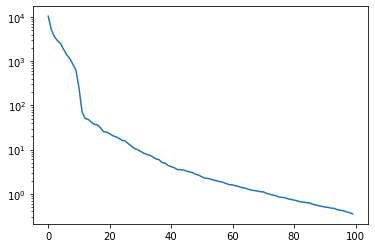

In [82]:
plt.semilogy(S.cpu().detach().numpy())

In [69]:
A1.shape

torch.Size([128, 512])

In [23]:
trainloader.batch_size

128

In [32]:
batch_x.shape

torch.Size([128, 3, 32, 32])